assume we have a radar that sends a periodic signal with the following properties:
1. PRI is the period.
2. CPI is the entire tarnsmition time. 
3. fc is the carrier wave

the signal itself is a chirp described by the equation: 
h(t) = exp(i*pi*(B/pw)*(t-(pw/2)) , 0<t<pw
       0                          , O.W
                                       
where B is the bandwidth and pw is the width of the pulse. 
                                           
now we set the following parameters:
                                         
                                          
1.PRI = 5uses

2.pw  = 2usec            

3.CPI = 0.5msec

4.B   = 100MHz

5.fc  = 40GHz
                                           
the speed of light is c = 3e8m/s
                                           
also we have a target in a distance of 400m and it is moving away from our radar with velocity of v=100m/s.
                                           
we are going to use a Doppler-range-map in order to find the distance and the velocity of the target. 
                                           
also, the recieved signal has an amplitude "sigma" and an added Gaussian noise w(t) with mean 0 and variance, v^2. 

In [8]:
import numpy as np
import math

class radar:
    def __init__(self, parameters):
        self.pw = parameters["pw"]
        self.PRI = parameters["PRI"]
        self.cpi = parameters["cpi"]
        self.fc = parameters["fc"]
        self.B = parameters["B"]
        self.f_s = parameters["f_s"]
        self.t_s = 1/self.f_s
        self.c = parameters["c"]
        self.printer = 1

    def create_transmitted_signal(self, v):
        self.v = v

        # creating time vectors for pulse, period and the entire signal
        self.t_pulse = np.arange(0, self.pw - self.t_s / 2, self.t_s, dtype=float)
        self.t_period = np.arange(0, self.PRI - self.t_s / 2, self.t_s, dtype=float)
        self.t_total = np.arange(0, self.cpi - self.t_s / 2, self.t_s, dtype=float)

        num_of_zeros_in_pulse = int(len(self.t_pulse) * (self.PRI - self.pw) / self.pw)

        # creating the signal:
        # pulse - transmition
        h_pulse = np.exp((1j * math.pi) * (self.B / self.pw) * ((self.t_pulse) - self.pw / 2) ** 2)
        # adding zeros
        self.h_period = np.hstack((h_pulse, np.zeros(num_of_zeros_in_pulse)))
        # repeating 100 time (5us per period -> 0.5ms the entire signal
        self.h_total = np.tile(self.h_period, int(np.round(self.cpi / self.PRI)))

        # creating frequencies vectors
        # 1 pulse
        omega_pulse = self.t_pulse * 2 * np.pi / self.pw
        # 1 period
        self.omega_period = self.t_period * 2 * np.pi / self.PRI
        # the entire signal
        self.omega_total = self.t_total * 2 * np.pi / self.cpi

        hc = self.h_total * np.exp(2j * np.pi * self.fc * self.t_total)

        #calculaitng autocorrelation
        ACF = np.correlate(h_pulse, h_pulse, mode='full')
        ACF = ACF[int(np.floor(ACF.shape[0]/2)):]

        return hc, ACF

    def creat_received_signal(self, R0, sigma):
        self.delta_t = (self.v / self.c)

        # delay between transmition and recieving
        t_shift = 2 * R0 / self.c

        # creating a longer time vector because of the delay
        # time_vector = np.arange(0, 0.0005+t_shift, t_s, dtype=float)
        time_vector = np.arange(0, self.cpi, self.t_s, dtype=float)
        # calculating the delay in sample time units
        number_of_zeors_shift = int(t_shift / self.t_s) + 1
        # number_of_zeors_shift_ = int(t_shift_/t_s)+1
        self.carrier = np.exp(2j * np.pi * self.fc * time_vector)
        self.adjusted_carrier = np.exp(2j * np.pi * self.fc * time_vector * (1 + 2 * self.delta_t))
        St = self.h_total * self.carrier
        Sr = np.roll(self.h_total * self.adjusted_carrier, number_of_zeors_shift)

        self.Sr_base = Sr * self.carrier
        self.num_of_pulses = int(np.round(self.cpi / self.PRI))
        self.Sr_base_single_pulse = self.Sr_base[:int(self.Sr_base.shape[0] / self.num_of_pulses)]
        self.Sr_base_double_pulse = self.Sr_base[:2 * int(self.Sr_base.shape[0] / self.num_of_pulses)]
        self.h_double_pulse = self.h_total[:2 * int(self.h_total.shape[0] / self.num_of_pulses)]

        return Sr

    def create_doppler_range_map(self, Sr, SNR=0, i=0):
        w=0
        if SNR!=0:
            np.random.seed(i * 2)
            v_w = 1/SNR
            if self.printer==1:
                print("v(w) :" + str(v_w))
            Pin = np.abs(sum(Sr * Sr.conj()))
            w = np.random.normal(0, np.sqrt(v_w), Sr.size)

        Sr = Sr + w
        Sr_base = Sr * self.carrier
        num_of_pulses = int(np.round(self.cpi / self.PRI))
        Sr_base_single_pulse = Sr_base[:int(Sr_base.shape[0] / num_of_pulses)]
        Sr_base_double_pulse = Sr_base[:2 * int(Sr_base.shape[0] / num_of_pulses)]
        h_double_pulse = self.h_total[:2 * int(self.h_total.shape[0] / num_of_pulses)]

        # --------------------------------------------------------------------------
        Sr_base_mat = Sr_base.reshape([num_of_pulses, int(Sr.shape[0] / num_of_pulses)])
        h_total_mat = self.h_total.reshape([num_of_pulses, int(self.h_total.shape[0] / num_of_pulses)])

        # calculate correlation
        corr_list = list()
        for k in range(h_total_mat.shape[0]):
            corr_k = np.correlate(Sr_base_mat[k], h_total_mat[k], mode='full')
            corr_k = corr_k[int(np.floor(corr_k.shape[0] / 2)):]
            corr_list.append(corr_k)
        corr_mat = np.array(corr_list)

        D_R_m = np.roll(np.fft.fft(corr_mat.T), int(corr_mat.shape[0] / 2)).T

        max_loc_x = np.where(np.abs(np.fft.fft(corr_mat.T).T) == np.max(np.abs(D_R_m)))[0][0]
        sign = 1
        if max_loc_x > D_R_m.shape[0] / 2:
            max_loc_x = D_R_m.shape[0] - max_loc_x
            sign = -1
        max_loc_y = np.where(np.abs(D_R_m) == np.max(np.abs(D_R_m)))[1][0]

        # estimated velocity
        omega = max_loc_x / ((D_R_m.shape[0] * D_R_m.shape[1]) * self.t_s)
        estimated_v = sign * omega * self.c / (2 * self.fc)
        if self.printer==1:
            print("estimated velocity: " + str(estimated_v) + "m/s")
        # estimated velocity resolution
            print("velocity resolution: " + str(self.c * (2 - 1) / (((D_R_m.shape[0] * D_R_m.shape[1]) * self.t_s) * 2 * self.fc)) + "m/s")
        # estimated distance
        estimated_R0 = (self.t_s * self.c) * max_loc_y / 2
        if self.printer==1:
            print("estimated range: " + str(estimated_R0) + "m")
        # estimated distance resolution
            res = (self.t_s * self.c) * max_loc_y / 2 - (self.t_s * self.c) * (max_loc_y - 1) / 2
            print("distance resolution: " + str(res) + "m")

        return corr_mat, D_R_m, estimated_R0, estimated_v


    def multyple_experiments(self, sr, snrs, dist, velocity, num_of_exp):
        self.printer = 0
        total_dist_list = list()
        total_range_list = list()
        total_detect_list = list()
        for snr in snrs:
            velocity_list = list()
            range_list = list()
            for i in range(0, num_of_exp):
                corr_mat, D_R_m, estimated_R0, estimated_v = self.create_doppler_range_map(sr, snr, i)

                range_list.append(estimated_R0)
                velocity_list.append(estimated_v)

                # default = 400.5 97.5
                # 2*freq = 400.125, 97.5
                # 2*cpi = 400.5, 101.25
            detect_list = [(r, t) for (r, t) in zip(range_list, velocity_list) if r == dist and t == velocity]

            print(100 * len(detect_list) / num_of_exp)
            total_detect_list.append(100 * len(detect_list) / num_of_exp)
            total_dist_list.append(velocity_list)
            total_range_list.append(range_list)

        return total_detect_list

In [9]:
#first, we define our parameter
from radar_ex_class import radar
import matplotlib.pyplot as plt
import numpy as np

parameters = dict()
parameters["pw"]  = 2e-6
parameters["PRI"] = 5e-6
parameters["cpi"] = 0.5e-3
parameters["fc"]  = 40e9
parameters["B"]   = 100e6
parameters["f_s"] = 2*parameters["B"]
parameters["c"] = 3e8
t_s = 1/parameters["f_s"]

rad = radar(parameters)
v= 100

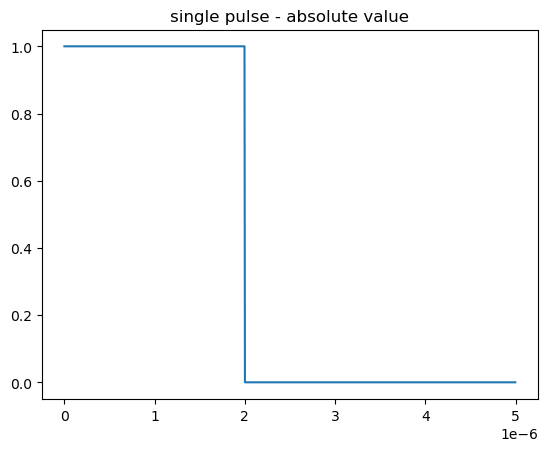

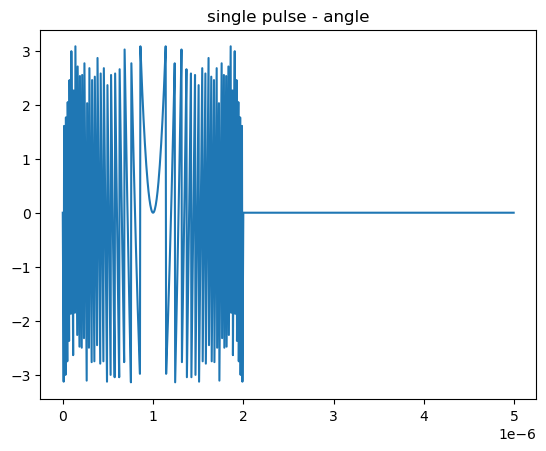

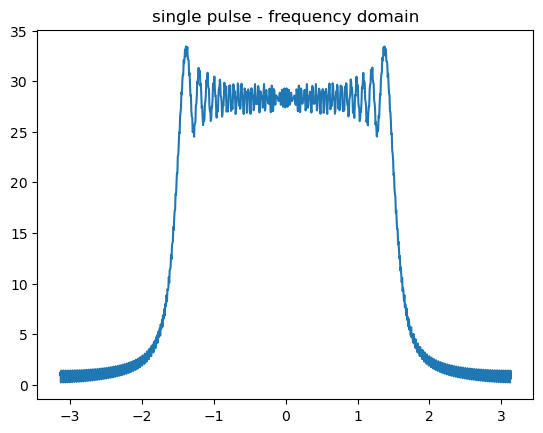

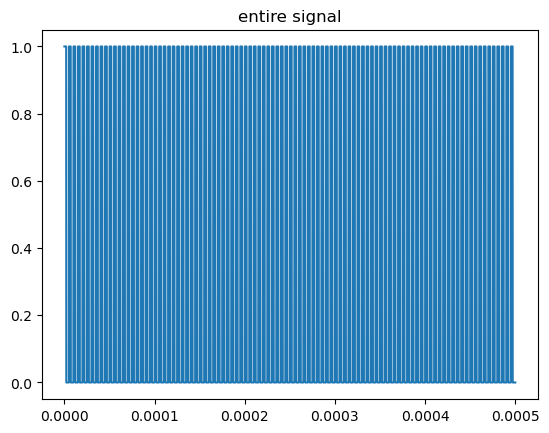

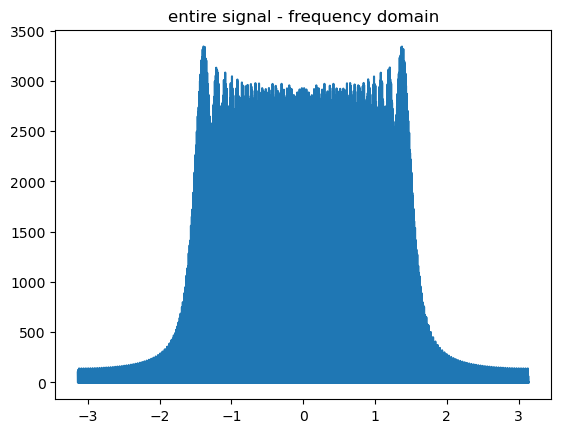

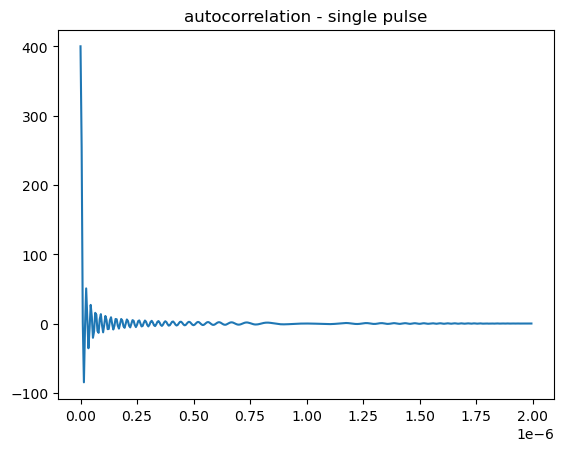

In [10]:
#next, we define the transmitted signal:
#1. we generate time vectors for a pulse, a period and the entire signal with sampling rate that we choose according to 
#Nyquist condition: notice that the bandwidth is B so for real signal it would be symmetric so that according to Nyquist
#the sampling frequncy should be fs>4B - but, since the signal is complex, the nyquist condition is fs>2B. 
#2. we sample the given signal is the frequncy fs for pw.
#3. we add zores for the rest of the PRI. 
#4. we repeat that signal as many cpi/PRI times. 

st, corr = rad.create_transmitted_signal(v)

#plots of the signal and the autocorrelation function:
plt.plot(rad.t_period, np.abs(rad.h_period))
plt.title("single pulse - absolute value")
plt.show()
# plot of the angle of the signal
plt.plot(rad.t_period, np.angle(rad.h_period))
plt.title("single pulse - angle")
plt.show()
#single pulse plot - frequency domain
plt.plot(rad.omega_period-np.pi, np.roll(np.abs(np.fft.fft(rad.h_period)), int(rad.omega_period.shape[0]/2)))
plt.title("single pulse - frequency domain")
plt.show()
#entire signal
plt.plot(rad.t_total, np.abs(rad.h_total))
plt.title("entire signal")
plt.show()
#entire signal - frequency domain
plt.plot(rad.omega_total-np.pi, np.roll(np.abs(np.fft.fft(rad.h_total)), int(rad.omega_total.shape[0]/2)))
plt.title("entire signal - frequency domain")
plt.show()
#autocorrelation function
plt.plot(rad.t_pulse, corr)
plt.title("autocorrelation - single pulse")
plt.show()

1. the absolute value of the signal is 1 - that's what we get when we multiply a phase with its hermitian conjegate. 
2. the information and the patteren in the frequency domain rests in the angle. 
3. if we look at the entire cpi, we get better resolution in the frequency domain: fft take N points in the time domain and calculate N points in the freqeuncy domain. the frequncies of a sampled signal is always between -pi and pi so if we take more samples of a periodic signal, we will get the same frequncies but we will have more data point, i.e, better resulotion. Also, the amplitude will increase according to the number of periods. 
4. the auto correlation matrix is similar (but not exactly the same) as a convoluiton - multiplication and summation and then shift by one sample and again and again... so the highest correlation of a signale with itself will be at the first sampel and in our case, it will be a summation of ones (multiplication of a phase with its hermitian conjegate). 
5. in case we calculate the correlation function between a signal and a delyed signal, the highest correlation will tell us the delay between the signal. 

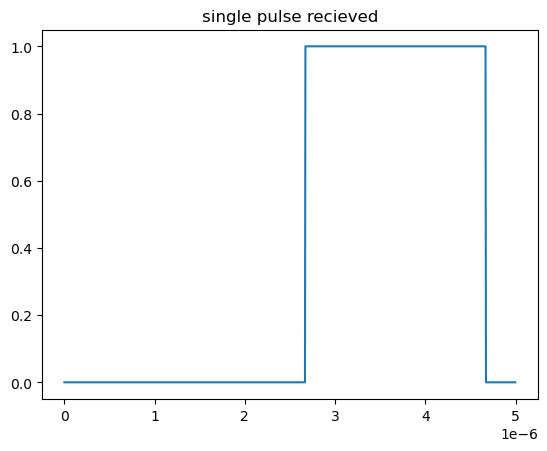

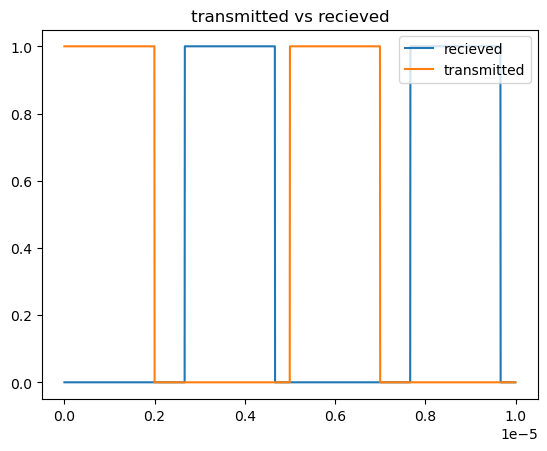

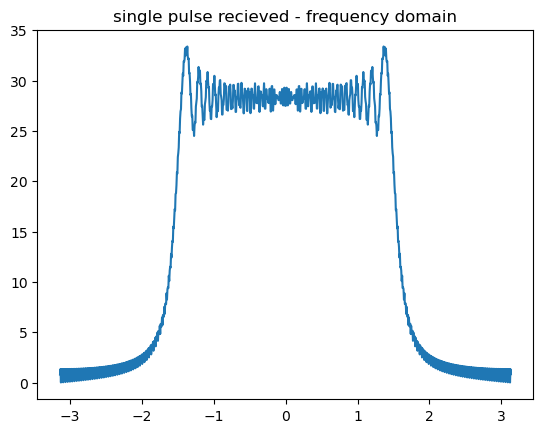

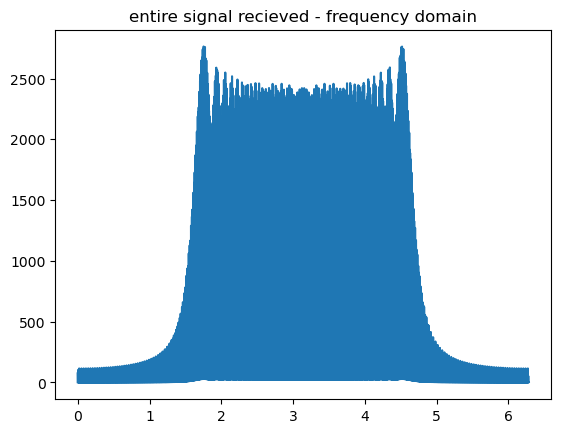

In [11]:

R0 = 400
sigma = 1

#the recieved signal is exactly the same as the transmitted signal with one exception: the carrier wave gets a little
#more phase with each sample. (in pratice, there is also a delay of the signal, but it is negligible). 
#the form of thr carrier wave is exp(jwt) but becuase the target is moving, t becomes t+tv/c and the phsae becomes:
#exp(jwt(1+v/c)) - so we can actually say that the frequncy that we will see is: w(1+v/c) - and that my freinds, is:
#the Doppler effect. 
sr = rad.creat_received_signal(R0, sigma)

plt.plot(rad.t_period, np.abs(rad.Sr_base_single_pulse))
plt.title("single pulse recieved")
plt.show()
#transmitted vs recieved
plt.plot(rad.t_total[:2*int(rad.t_total.shape[0]/rad.num_of_pulses)], np.abs(rad.Sr_base_double_pulse), label="recieved")
plt.plot(rad.t_total[:2*int(rad.t_total.shape[0]/rad.num_of_pulses)], np.abs(rad.h_double_pulse), label="transmitted")
plt.title("transmitted vs recieved")
plt.legend(loc="upper right")
plt.show()
#frequency domain
plt.plot(rad.omega_period-np.pi, np.roll(np.abs(np.fft.fft(rad.Sr_base_single_pulse)), int(rad.Sr_base_single_pulse.shape[0]/2)))
plt.title("single pulse recieved - frequency domain")
plt.show()
#entire signal
plt.plot(rad.omega_total, np.roll(np.abs(np.fft.fft(rad.Sr_base)), int(rad.Sr_base.shape[0]/2)))
plt.title("entire signal recieved - frequency domain")
plt.show()

since the shift in the frequncy is w*v/c so it's around 10KHz it is not visiable in the plots because in comparison to the frequency of the carrier wave (40GHz) it is negligible.
but it will have crucial significants as we will see in the next step. 

estimated velocity: 97.5m/s
velocity resolution: 7.5m/s
estimated range: 400.5m
distance resolution: 0.75m


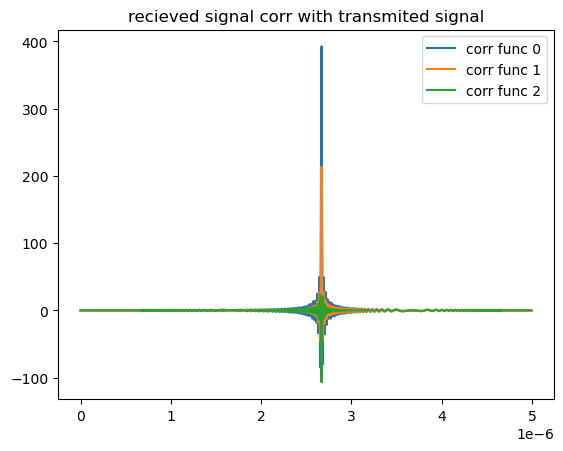

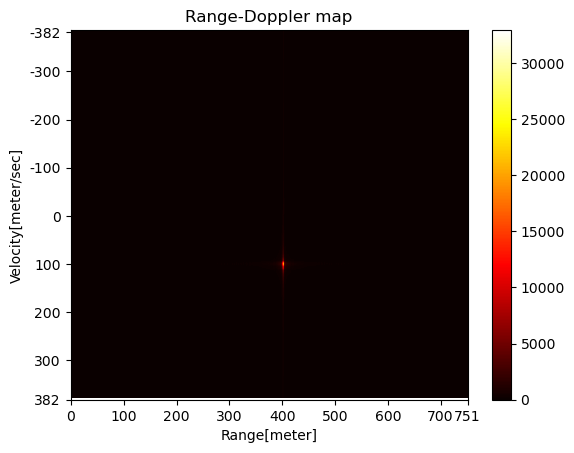

In [12]:
corr_mat, D_R_m, estimated_R0, estimated_v = rad.create_doppler_range_map(sr)#1.5e-3

plt.plot(rad.t_period, corr_mat[0], label="corr func 0")
plt.plot(rad.t_period, corr_mat[1], label="corr func 1")
plt.plot(rad.t_period, corr_mat[2], label="corr func 2")
plt.title("recieved signal corr with transmited signal")
plt.legend(loc="upper right")
plt.show()

#range calculation
max_v = D_R_m.shape[0]+2
max_omega = (max_v)/((D_R_m.shape[0]*D_R_m.shape[1])*t_s)
max_est_v  = int(max_omega*parameters["c"]/(2*parameters["fc"]))/2

max_R0 = D_R_m.shape[1]+2
max_est_R0 = (t_s*parameters["c"])*max_R0/2

#plot - doppler range map
plt.imshow(np.abs(D_R_m), cmap='hot', aspect='auto')
plt.colorbar()
adjusted_x = np.array(list(range(0, 100*int(max_est_R0/100)+100, 100))+[int(max_est_R0)])
default_x_ticks = 2*adjusted_x/(t_s*parameters["c"])
plt.xticks(default_x_ticks, adjusted_x)
adjusted_y = np.array([-int(max_est_v)]+list(range(-100*int(max_est_v/100), 100*int(max_est_v/100)+100, 100))+[int(max_est_v)])
default_y_ticks = (2*parameters["fc"]*(D_R_m.shape[0]*D_R_m.shape[1])*t_s*adjusted_y/parameters["c"])
default_y_ticks = (default_y_ticks-default_y_ticks[0])*D_R_m.shape[0]/(default_y_ticks[-1]-default_y_ticks[0])
plt.yticks(default_y_ticks, adjusted_y)
plt.title("Range-Doppler map")
plt.xlabel("Range[meter]")
plt.ylabel("Velocity[meter/sec]")
plt.show()

In the first plot we see the shift in time between the transmitted signal and the recieved signal which tells us the distance. 
also, we see that the amplitude is changing with each pulse - this is due to the Doppler effect and and from this we can calculate the velocity using fft which will tell us the the frequency of that change. 

1. If we want to increas the resolution for the distance, we can use higher sampling frequency. However, it will shorten the detectable distance by that factor due to aliasing.  
2. If we want to increase thr resolution for the velocity, we can increase the number of pulses (increase the cpi will get us more pulses). However, it will allow us to detect smaller velocities by that factor. 

100.0
100.0
99.0
95.0
85.0
47.0
25.0
11.0
3.0
0.0
0.0
0.0
estimated velocity: 101.25m/s
velocity resolution: 3.75m/s
estimated range: 400.5m
distance resolution: 0.75m
100.0
100.0
100.0
100.0
100.0
99.0
80.0
45.0
4.0
0.0
0.0
0.0


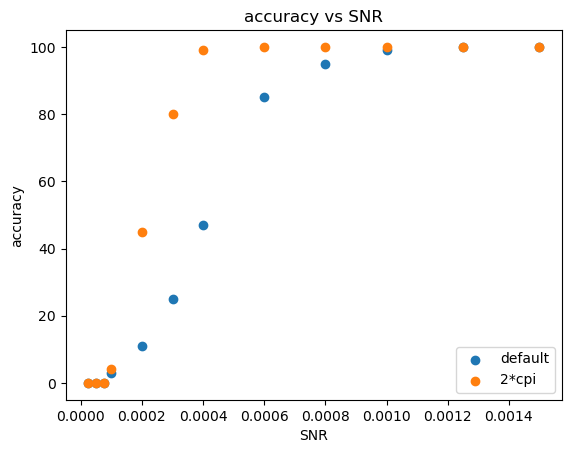

done


In [13]:
#1000 experiments
snrs = [1.5e-3, 1.25e-3, 1e-3, 8e-4, 6e-4, 4e-4, 3e-4, 2e-4, 1e-4, 7.5e-5, 5e-5, 2.5e-5]
# default = 400.5 97.5
# 2*freq = 400.125, 97.5
# 2*cpi = 400.5, 101.25
# 625.5 0
total_detect_list = rad.multyple_experiments(sr, snrs, 400.5, 97.5, 100)

parameters["cpi"] = 2*0.5e-3
rad_2_cpi = radar(parameters)
st_2_cpi, corr_2_cpi = rad_2_cpi.create_transmitted_signal(v)
sr_2_cpi = rad_2_cpi.creat_received_signal(R0, sigma)
corr_mat_2_cpi, D_R_m_2_cpi, estimated_R0_2_cpi, estimated_v = rad_2_cpi.create_doppler_range_map(sr_2_cpi)
total_detect_list_2_cpi = rad_2_cpi.multyple_experiments(sr_2_cpi, snrs, 400.5, 101.25, 100)


plt.scatter(snrs, total_detect_list, label="default")
plt.scatter(snrs, total_detect_list_2_cpi, label="2*cpi")
plt.legend(loc="lower right")
plt.xlabel("SNR")
plt.ylabel("accuracy")
plt.title("accuracy vs SNR")
plt.show()
print("done")

When adding noise, the probabilty for detection decrease. we can improve that probability by increasing the cpi - as we can see in the plot above.
This is because of the fact that the SNR is calculate for the averge energy of the signal but when we are trying to detect the recieved signal, we use the correlation function which sums up the multiplication of the signals in at each point in time - so in average, the SNR stays the same but where it is of intrest to us, the energy is much higher. 